In [1]:
import numpy as np
from collections import deque
from scipy.special import logsumexp,softmax
import matplotlib.pyplot as plt
import img_utils
from sklearn.preprocessing import PolynomialFeatures
from scipy.linalg import block_diag
import pandas as pd

In [2]:
csfont = {'fontname':'Times New Roman'}# changes only the mathcal subfamily

In [3]:
def linear(x,y):
  return 5*y+x
def twoD(z):
  y = z//5
  x = z%5
  return x,y
#X = 0,1,2,3,4
#Y = 0,1,2,3,4
#action: 0=stay, 1= left,2=right,3=up,4=down

def step(x,y,action):
  if action ==0:
    new_x = x
    new_y = y
  if action ==1:
    new_x = max(0,x-1)
    new_y = y
  if action == 2:
    new_x = min(4,x+1)
    new_y = y
  if action ==3:
    new_x = x
    new_y = max(0,y-1)
  if action ==4:
    new_x = x
    new_y = min(4,y+1)
  return new_x,new_y
def step_z(z,action):
  x,y = twoD(z)
  new_x,new_y = step(x,y,action)
  new_z = linear(new_x,new_y)
  return new_z
def step_xy(xy,action):
  x,y = xy
  new_x,new_y = step(x,y,action)
  return np.array([new_x,new_y])
def linear_xy(xy):
  x,y = xy
  return linear(x,y)
def one_hot(x):
  return np.arange(25)==x

In [4]:
gamma = 0.9

In [5]:
dynamic = np.zeros((5,25,25))
for a in range(5):
  for z in range(25):
    x,y = twoD(z)
    new_x,new_y = step(x,y,a)
    new_z = linear(new_x,new_y)
    dynamic[a][z][new_z] = 1

In [6]:
reward_true = np.zeros(25)
reward_true[linear(1,1)] = 1
reward_true[linear(3,3)] = 1

In [7]:
q_true = np.zeros((25,5))
alpha = 1
for _ in range(1000):
  v_true = alpha*logsumexp(q_true/alpha,axis =1)
  for a in range(5):
    q_true[:,a] = gamma*dynamic[a].dot(v_true)+reward_true

In [8]:
reward_true =v_true-v_true.min()
reward_true /=reward_true.max()
reward_true = np.round(reward_true,1)

map shape: (5, 5), data type: float64


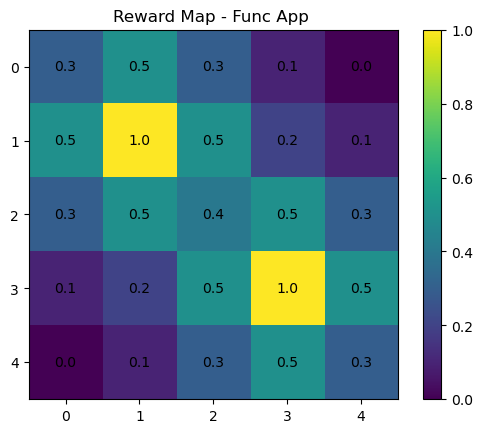

In [9]:
img_utils.heatmap2d(reward_true.reshape(5,5), 'Reward Map - Func App ', block=False)
plt.margins(0.5) 
#plt.savefig('Reward_map.pdf')

In [10]:
q_true = np.zeros((25,5))
alpha = 1
for _ in range(1000):
  v_true = alpha*logsumexp(q_true/alpha,axis =1)
  for a in range(5):
    q_true[:,a] = gamma*dynamic[a].dot(v_true)+reward_true

map shape: (5, 5), data type: float64


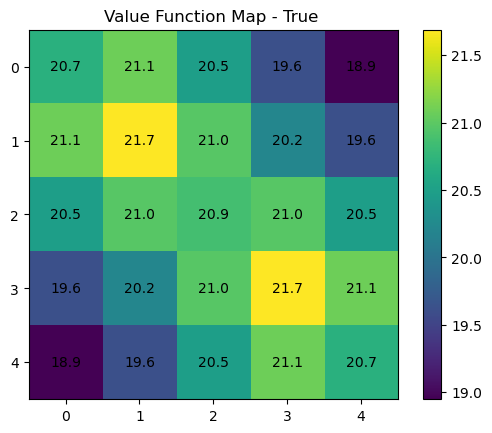

In [11]:
img_utils.heatmap2d(v_true.reshape(5,5), 'Value Function Map - True ', block=False)

In [12]:
uniform_policy = np.ones((25,5))/5
def pi_dy(pi):
  pi_dynamic = np.zeros((25,25))
  for i in range(5):
    pi_dynamic += pi[:,i].reshape(-1,1)*dynamic[i]
  return pi_dynamic
pi_dynamic_uniform = pi_dy(uniform_policy)
rho_0 = np.ones(25)/25 #uniform initial distribution 
def stationary(state_dy):
    rho = rho_0
    for _ in range(10000):
        rho = rho @ state_dy
    return rho
rho_uniform = stationary(pi_dynamic_uniform)
D = np.diag(np.repeat(rho_uniform,5)/5)

In [13]:
poly = PolynomialFeatures(2)
def phi(x,y,a):
    basis = poly.fit_transform(np.array([x/5,y/5]).reshape(1,-1))[0]
    return np.hstack([basis*(a== i) for i in range(5)])
Phi_0 = np.vstack([phi(x,y,0) for x in range(5) for y in range(5)])
Phi_1 = np.vstack([phi(x,y,1) for x in range(5) for y in range(5)])
Phi_2 = np.vstack([phi(x,y,2) for x in range(5) for y in range(5)])
Phi_3 = np.vstack([phi(x,y,3) for x in range(5) for y in range(5)])
Phi_4 = np.vstack([phi(x,y,4) for x in range(5) for y in range(5)])
Phi = np.vstack((Phi_0,Phi_1,Phi_2,Phi_3,Phi_4))
Sigma = Phi.T@D@Phi
Sigma_inv = np.linalg.inv(Sigma)

In [14]:
Q_dynamic = np.vstack([dynamic[i] for i in range(5)])
reward_repeat = np.tile(reward_true,5)

In [15]:
theta_proj = Sigma_inv@Phi.T@D@(q_true.T.flatten())
q_proj =  (Phi@theta_proj).reshape(-1,25).T
v_proj = logsumexp(q_proj,axis = 1)

map shape: (5, 5), data type: float64


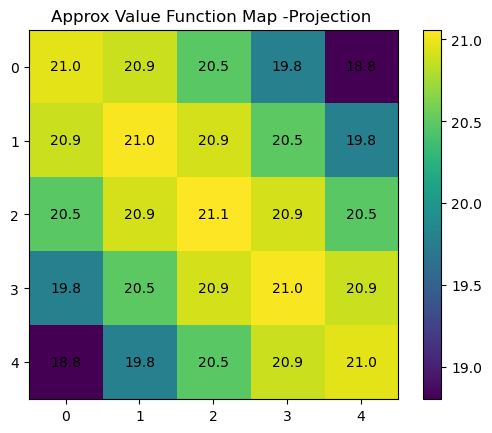

In [16]:
img_utils.heatmap2d(v_proj.reshape(5,5), 'Approx Value Function Map -Projection ', block=False)

In [17]:
np.square(v_proj-v_true).sum()

1.5630333199946642

In [18]:
theta_original = np.zeros(Phi.shape[1])
for i in range(10000):
    theta_original = Sigma_inv@Phi.T@D@((reward_repeat+gamma*Q_dynamic@logsumexp((Phi@theta_original).reshape(-1,25).T,axis =1)))

In [19]:
q_original = (Phi@theta_original).reshape(-1,25).T
v_original = logsumexp(q_original,axis = 1)

map shape: (5, 5), data type: float64


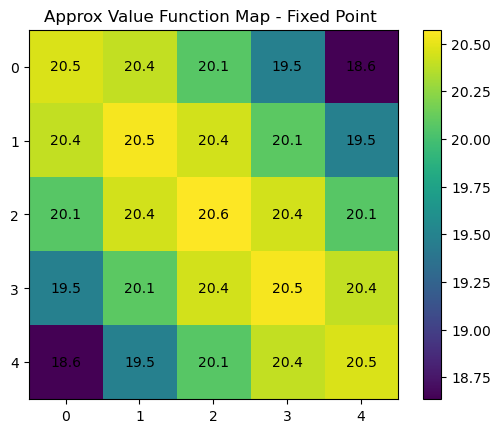

In [20]:
img_utils.heatmap2d(v_original.reshape(5,5), 'Approx Value Function Map - Fixed Point ', block=False)

In [21]:
#smooth truncation
def s_truncate(x,c):
    return c * np.tanh(x/c)

In [22]:
#delta = (1+log 5)/(1-gamma)
C = (1+np.log(5))/(1-gamma)
theta_smooth_1 = np.zeros(Phi.shape[1])
for i in range(10000):
    theta_smooth_1 = Sigma_inv@Phi.T@D@((reward_repeat+gamma*Q_dynamic@s_truncate(logsumexp((Phi@theta_smooth_1).reshape(-1,25).T,axis =1),C)))

In [23]:
q_st_1 = (Phi@theta_smooth_1).reshape(-1,25).T
v_st_1 = logsumexp(q_st_1,axis = 1)

map shape: (5, 5), data type: float64


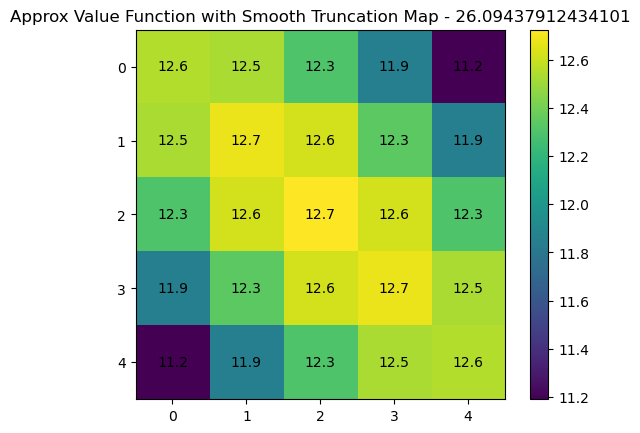

In [24]:
img_utils.heatmap2d(v_st_1.reshape(5,5), f'Approx Value Function with Smooth Truncation Map - {C}', block=False)

In [25]:
#delta = (1+log 5)/(1-gamma)
C = 5*(1+np.log(5))/(1-gamma)
theta_smooth_2 = np.zeros(Phi.shape[1])
for i in range(10000):
    theta_smooth_2 = Sigma_inv@Phi.T@D@((reward_repeat+gamma*Q_dynamic@s_truncate(logsumexp((Phi@theta_smooth_2).reshape(-1,25).T,axis =1),C)))

In [26]:
q_st_2 = (Phi@theta_smooth_2).reshape(-1,25).T
v_st_2 = logsumexp(q_st_2,axis = 1)

map shape: (5, 5), data type: float64


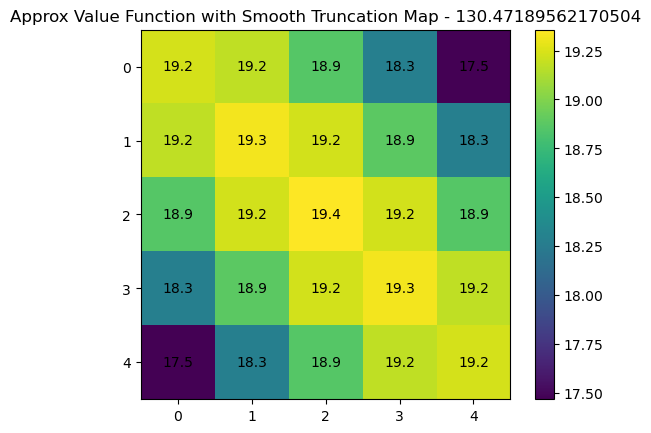

In [27]:
img_utils.heatmap2d(v_st_2.reshape(5,5), f'Approx Value Function with Smooth Truncation Map - {C}', block=False)

In [28]:
#delta = (1+log 5)/(1-gamma)
C = 10*(1+np.log(5))/(1-gamma)
theta_smooth_3 = np.zeros(Phi.shape[1])
for i in range(10000):
    theta_smooth_3 = Sigma_inv@Phi.T@D@((reward_repeat+gamma*Q_dynamic@s_truncate(logsumexp((Phi@theta_smooth_3).reshape(-1,25).T,axis =1),C)))

In [29]:
q_st_3 = (Phi@theta_smooth_3).reshape(-1,25).T
v_st_3 = logsumexp(q_st_3,axis = 1)

map shape: (5, 5), data type: float64


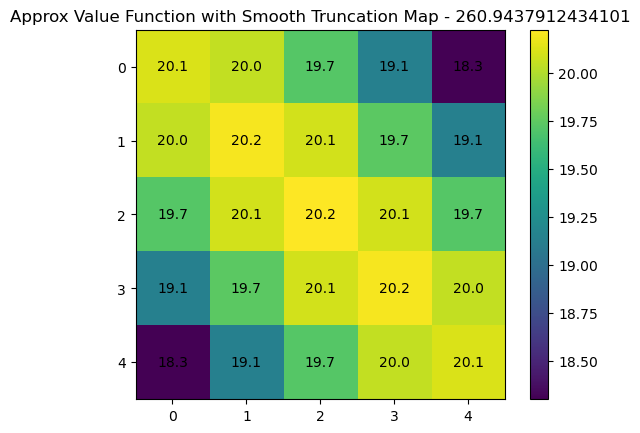

In [30]:
img_utils.heatmap2d(v_st_3.reshape(5,5), f'Approx Value Function with Smooth Truncation Map - {C}', block=False)

In [31]:
#delta = (1+log 5)/(1-gamma)
C = 30*(1+np.log(5))/(1-gamma)
theta_smooth_4 = np.zeros(Phi.shape[1])
for i in range(10000):
    theta_smooth_4 = Sigma_inv@Phi.T@D@((reward_repeat+gamma*Q_dynamic@s_truncate(logsumexp((Phi@theta_smooth_4).reshape(-1,25).T,axis =1),C)))

In [32]:
q_st_4 = (Phi@theta_smooth_4).reshape(-1,25).T
v_st_4 = logsumexp(q_st_4,axis = 1)

map shape: (5, 5), data type: float64


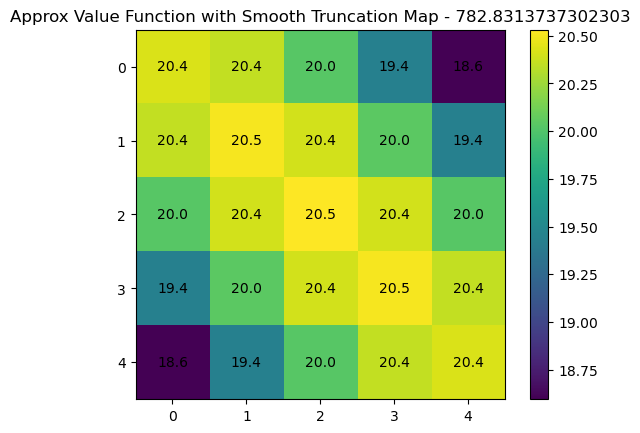

In [33]:
img_utils.heatmap2d(v_st_4.reshape(5,5), f'Approx Value Function with Smooth Truncation Map - {C}', block=False)

In [34]:
#Generalized smooth truncation
def gs_truncate(x,c1,c2):
    return (c2-c1)/2 * np.tanh((2*x-c1-c2)/(c2-c1))+(c2+c1)/2

In [35]:
C1= 0
C2 = (1+np.log(5))/(1-gamma)
theta_smooth_5 = np.zeros(Phi.shape[1])
for i in range(10000):
    theta_smooth_5 = Sigma_inv@Phi.T@D@((reward_repeat+gamma*Q_dynamic@gs_truncate(logsumexp((Phi@theta_smooth_5).reshape(-1,25).T,axis =1),C1,C2)))

In [38]:
q_st_5 = (Phi@theta_smooth_5).reshape(-1,25).T
v_st_5 = logsumexp(q_st_5,axis = 1)

map shape: (5, 5), data type: float64


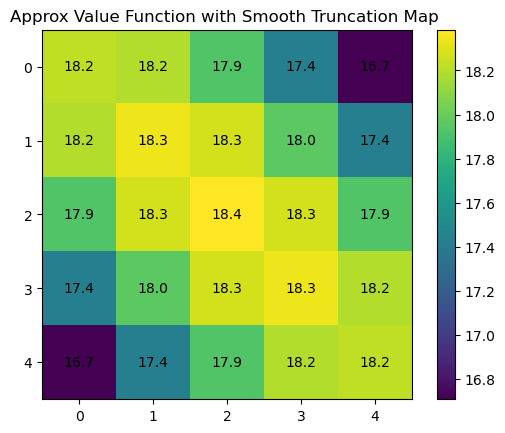

In [39]:
img_utils.heatmap2d(v_st_5.reshape(5,5), f'Approx Value Function with Smooth Truncation Map ', block=False)

In [40]:
map_values = [v_true,v_proj,v_original,v_st_1,v_st_3,v_st_4]
map_titles = [r'Optimal Value Function $V_{G,\tau}^*$','Projected Optimal Value \n'+r'Function $\Pi V_{G,\tau}^*$','Fixed Point of Projected \n Regularized Bellman Equation', 'Fixed Point with Smooth \n'+r'Truncation, $c = 1$','Fixed Point with Smooth \n'+r'Truncation, $c = 10$','Fixed Point with Smooth \n'+r'Truncation, $c = 30$']




In [41]:
def multi_heatmap2d(hm_mat, main = plt, text=True,cmap = 'viridis',colorbar = True,vmin = None,vmax = None):

  # plt.imshow(hm_mat, cmap='hot', interpolation='nearest')
  if vmin is not None:
      im = main.imshow(hm_mat, interpolation='nearest',cmap=cmap,vmin = vmin,vmax = vmax)
  else: 
      im= main.imshow(hm_mat, interpolation='nearest',cmap=cmap)
  if colorbar:
    plt.colorbar(im,ax = main)
  
  if text:
    for y in range(hm_mat.shape[0]):
      for x in range(hm_mat.shape[1]):
        main.text(x, y, '%.1f' % hm_mat[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

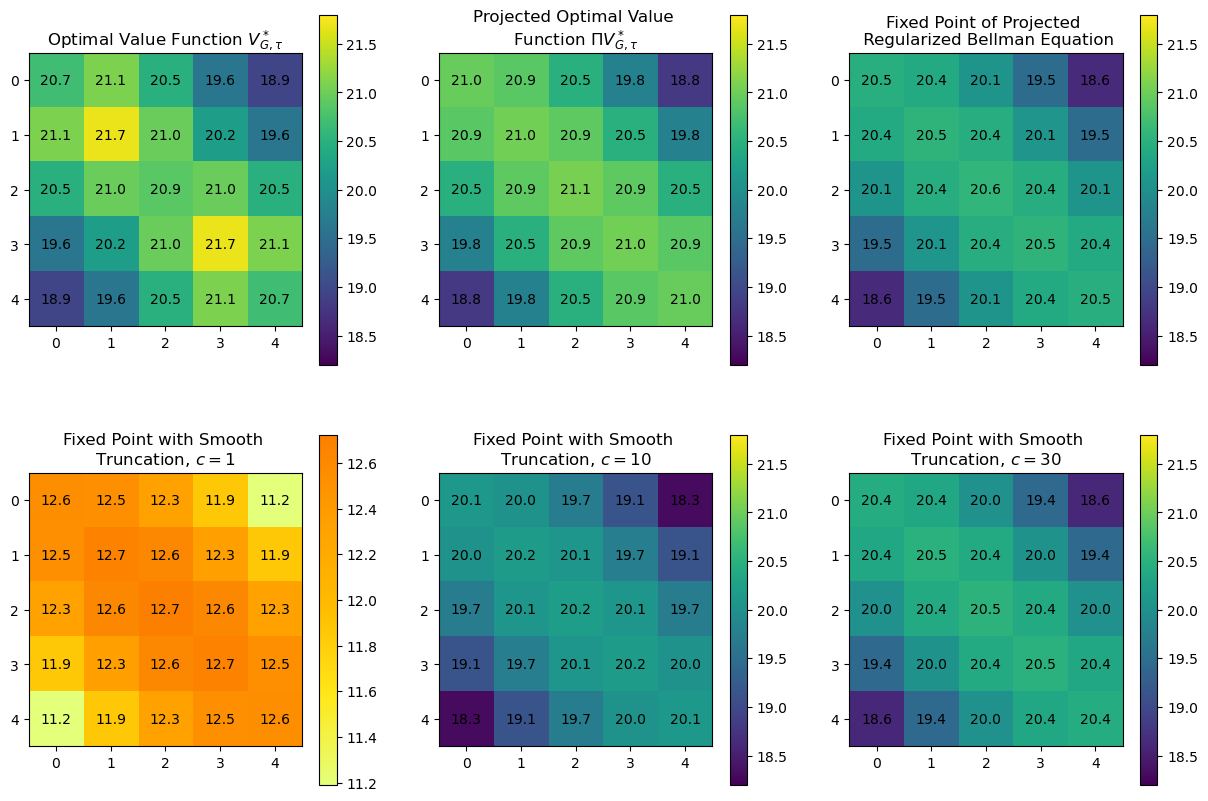

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for ax,value,subtitle in zip(axes.flat,map_values,map_titles):
    #ax.set_axis_off()
    if subtitle == 'Fixed Point with Smooth \n'+r'Truncation, $c = 1$':
        cmap = 'Wistia'
        vmin = None
        vmax = None
    else:
        cmap = 'viridis'
        vmin = 18.2
        vmax = 21.8
    multi_heatmap2d(value.reshape(5,5),main = ax,cmap = cmap,vmin = vmin,vmax = vmax)
    ax.set_title(subtitle)
plt.margins(0.5) 
#plt.savefig('Value Maps saved.pdf')

In [43]:
def single_heatmap2d(hm_mat, text=True,cmap = 'viridis',colorbar = True,vmin = None,vmax = None):

  # plt.imshow(hm_mat, cmap='hot', interpolation='nearest')
  if vmin is not None:
      im = plt.imshow(hm_mat, interpolation='nearest',cmap=cmap,vmin = vmin,vmax = vmax)
  else: 
      im= plt.imshow(hm_mat, interpolation='nearest',cmap=cmap)
  if colorbar:
    plt.colorbar(im)
  
  if text:
    for y in range(hm_mat.shape[0]):
      for x in range(hm_mat.shape[1]):
        plt.text(x, y, '%.1f' % hm_mat[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

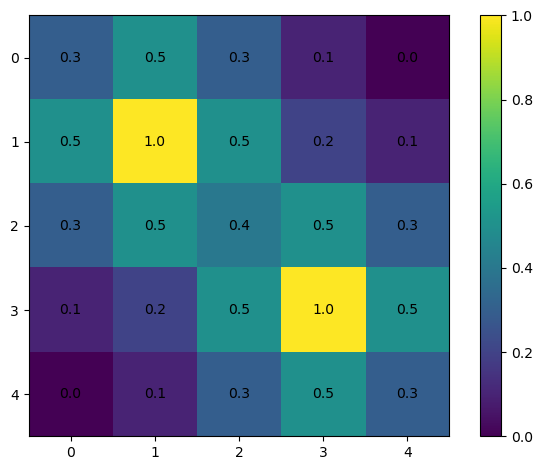

In [44]:
#Reward
cmap = 'viridis'
vmin = None
vmax = None
single_heatmap2d(reward_true.reshape(5,5),cmap = cmap,vmin = vmin,vmax = vmax)
plt.tight_layout()
plt.savefig('GridWorld_plot/Reward.pdf', bbox_inches='tight')

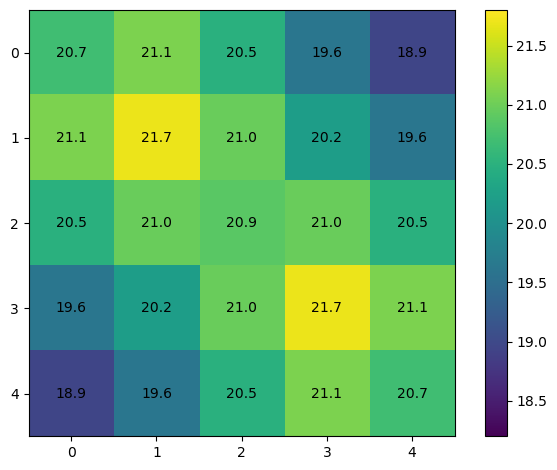

In [45]:
#Optimal True value function
cmap = 'viridis'
vmin = 18.2
vmax = 21.8
single_heatmap2d(map_values[0].reshape(5,5),cmap = cmap,vmin = vmin,vmax = vmax)
plt.tight_layout()
plt.savefig('GridWorld_plot/True_Value.pdf', bbox_inches='tight')

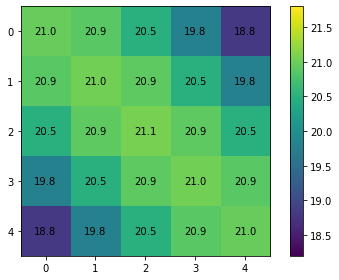

In [46]:
#Projected True value function
cmap = 'viridis'
vmin = 18.2
vmax = 21.8
single_heatmap2d(map_values[1].reshape(5,5),cmap = cmap,vmin = vmin,vmax = vmax)
plt.tight_layout()
plt.savefig('GridWorld_plot/Projected_True_Value.pdf', bbox_inches='tight')

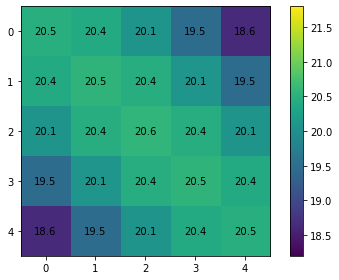

In [47]:
#Fixed Point without Truncation
cmap = 'viridis'
vmin = 18.2
vmax = 21.8
single_heatmap2d(map_values[2].reshape(5,5),cmap = cmap,vmin = vmin,vmax = vmax)
plt.tight_layout()
plt.savefig('GridWorld_plot/Fixed_Point.pdf', bbox_inches='tight')

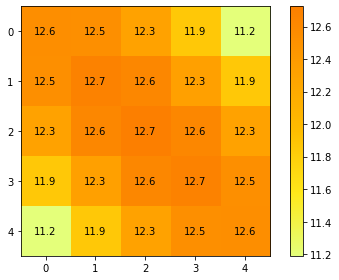

In [68]:
#Fixed Point with Truncation c= 1
cmap = 'Wistia'
vmin = None
vmax = None
single_heatmap2d(map_values[3].reshape(5,5),cmap = cmap,vmin = vmin,vmax = vmax)
plt.tight_layout()
plt.savefig('GridWorld_plot/Fixed_Point_Tr_c=1.pdf', bbox_inches='tight')

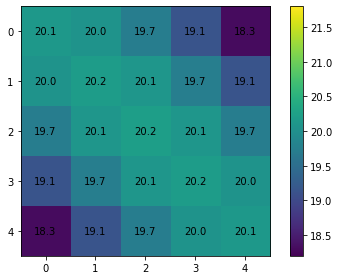

In [76]:
#Fixed Point with Truncation c= 10
cmap = 'viridis'
vmin = 18.2
vmax = 21.8
single_heatmap2d(map_values[4].reshape(5,5),cmap = cmap,vmin = vmin,vmax = vmax)
plt.tight_layout()
plt.savefig('GridWorld_plot/Fixed_Point_Tr_c=10.pdf', bbox_inches='tight')

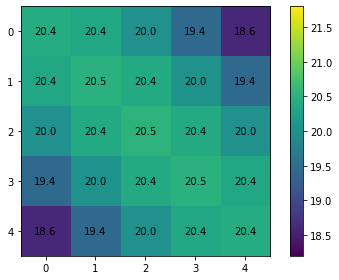

In [67]:
#Fixed Point with Truncation c= 30
cmap = 'viridis'
vmin = 18.2
vmax = 21.8
single_heatmap2d(map_values[5].reshape(5,5),cmap = cmap,vmin = vmin,vmax = vmax)
plt.tight_layout()
plt.savefig('GridWorld_plot/Fixed_Point_Tr_c=30.pdf', bbox_inches='tight')

Stochastic Env

In [46]:
nb_state = 25
theta_list_original= []
theta =  np.zeros(Phi.shape[1])
state = np.random.choice(25)
for i in range(20000):
    theta_list_original.append(theta.copy())
    action = np.random.choice(5)
    next_state = step_z(state,action)
    index = state + nb_state*action
    theta += 0.2*Phi[index]*(reward_repeat[index]+gamma*logsumexp((Phi@theta).reshape(-1,25).T,axis =1)[next_state]-Phi[index]@theta)
    state = next_state

In [47]:
sto_q_app = (Phi@theta).reshape(-1,25).T
sto_v_app = logsumexp(sto_q_app,axis =1)

map shape: (5, 5), data type: float64


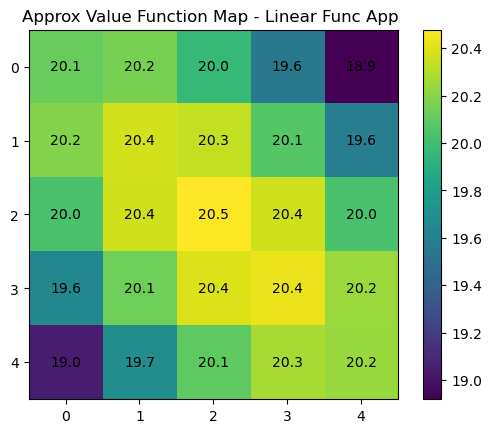

In [48]:
img_utils.heatmap2d(sto_v_app.reshape(5,5), 'Approx Value Function Map - Linear Func App ', block=False)

In [49]:
C = 10*(1+np.log(5))/(1-gamma)
nb_state = 25
theta =  np.zeros(Phi.shape[1])
state = np.random.choice(25)
for i in range(20000):
    action = np.random.choice(5)
    next_state = step_z(state,action)
    index = state + nb_state*action
    theta += 0.2*Phi[index]*(reward_repeat[index]+gamma*s_truncate(logsumexp((Phi@theta).reshape(-1,25).T,axis =1)[next_state],C)-Phi[index]@theta)
    state = next_state

In [50]:
sto_q_app_s = (Phi@theta).reshape(-1,25).T
sto_v_app_s = logsumexp(sto_q_app_s,axis =1)

map shape: (5, 5), data type: float64


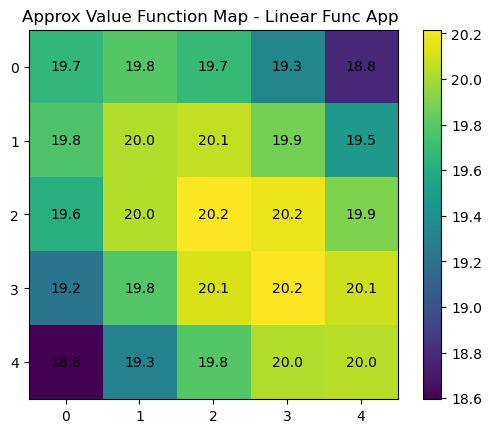

In [51]:
img_utils.heatmap2d(sto_v_app_s.reshape(5,5), 'Approx Value Function Map - Linear Func App ', block=False)

In [52]:
def policy(X):
    m = X.max(1)
    V = np.log(np.exp(X-m.reshape(-1,1)).sum(1))+m
    return np.exp(X-V.reshape(-1,1))

In [62]:
saved_model = dict()
seed_range = np.arange(100)
c_list = [1,2,3,5,10]

In [63]:
for seed in seed_range:
    print("Seed: ", seed)
    saved_model[seed] = dict()
    np.random.seed(seed)
    for c in c_list:
        C = c*(1+np.log(5))/(1-gamma)
        nb_action = 5
        saved_model[seed][c]= []
        theta =  np.zeros(Phi.shape[1])
        omega = np.zeros(Phi.shape[1])
        state = np.random.choice(25)
        for i in range(200000):
            if i == 0 or (i+1)%500 == 0:
                saved_model[seed][c].append(theta.copy())
            action = np.random.choice(5)
            next_state = step_z(state,action)
            index = state + nb_state*action
            omega += 0.5*Phi[index]*(reward_repeat[index]+gamma*s_truncate(logsumexp((Phi@theta).reshape(-1,25).T,axis =1)[next_state],C)-Phi[index]@omega)
            if np.linalg.norm(omega-theta) > 1e-4:
                theta += 0.05*(Phi[index] - (1-s_truncate(logsumexp((Phi@theta).reshape(-1,25).T,axis = 1)[next_state],C)**2/(C**2))*gamma*(policy((Phi@theta).reshape(-1,25).T)[next_state]@Phi[next_state*nb_action:(next_state+1)*nb_action]))*(Phi[index]@(omega-theta))/np.linalg.norm(omega-theta)
            state = next_state

Seed:  0
Seed:  1
Seed:  2
Seed:  3
Seed:  4
Seed:  5
Seed:  6
Seed:  7
Seed:  8
Seed:  9
Seed:  10
Seed:  11
Seed:  12
Seed:  13
Seed:  14
Seed:  15
Seed:  16
Seed:  17
Seed:  18
Seed:  19
Seed:  20
Seed:  21
Seed:  22
Seed:  23
Seed:  24
Seed:  25
Seed:  26
Seed:  27
Seed:  28
Seed:  29
Seed:  30
Seed:  31
Seed:  32
Seed:  33
Seed:  34
Seed:  35
Seed:  36
Seed:  37
Seed:  38
Seed:  39
Seed:  40
Seed:  41
Seed:  42
Seed:  43
Seed:  44
Seed:  45
Seed:  46
Seed:  47
Seed:  48
Seed:  49
Seed:  50
Seed:  51
Seed:  52
Seed:  53
Seed:  54
Seed:  55
Seed:  56
Seed:  57
Seed:  58
Seed:  59
Seed:  60
Seed:  61
Seed:  62
Seed:  63
Seed:  64
Seed:  65
Seed:  66
Seed:  67
Seed:  68
Seed:  69
Seed:  70
Seed:  71
Seed:  72
Seed:  73
Seed:  74
Seed:  75
Seed:  76
Seed:  77
Seed:  78
Seed:  79
Seed:  80
Seed:  81
Seed:  82
Seed:  83
Seed:  84
Seed:  85
Seed:  86
Seed:  87
Seed:  88
Seed:  89
Seed:  90
Seed:  91
Seed:  92
Seed:  93
Seed:  94
Seed:  95
Seed:  96
Seed:  97
Seed:  98
Seed:  99


MSPBE

In [59]:
def mspbe(x):
    y1 = Phi@Sigma_inv@Phi.T@D@((reward_repeat+gamma*Q_dynamic@logsumexp((Phi@x).reshape(-1,25).T,axis =1)))
    y2 = Phi@x
    return (y1-y2)@D@(y1-y2)

In [64]:
saved_mspbe = dict()
for c in c_list:
    saved_mspbe[c] = np.vstack([[mspbe(x) for x in saved_model[seed][c]] for seed in seed_range ])

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

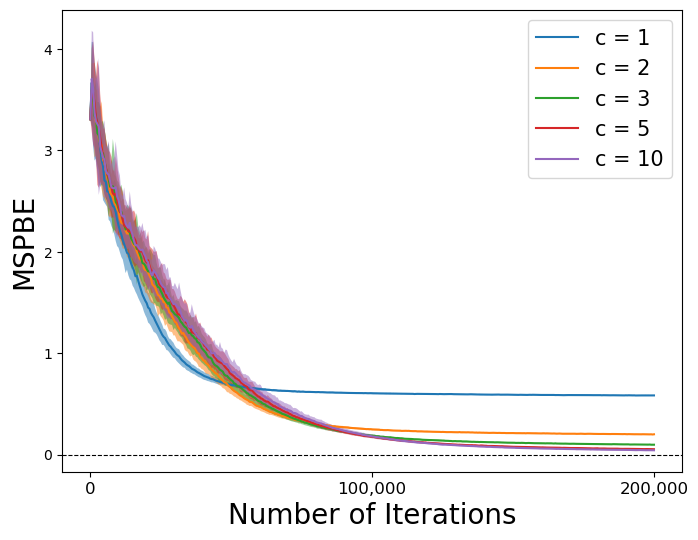

In [66]:
plt.figure(figsize=(8,6))
for c in c_list:#[1,10,30]:
    #smoothed_curve = pd.Series(saved_mspbe[c])
    #smoothed_y = smoothed_curve.rolling(window=1).mean()
    plt.plot(np.arange(401)*500,saved_mspbe[c].mean(0),label = f'c = {c}')
for c in c_list:#[1,10,30]:
    up_curve = saved_mspbe[c].mean(0) + saved_mspbe[c].std(0)
    down_curve = saved_mspbe[c].mean(0) - saved_mspbe[c].std(0)
    plt.fill_between(np.arange(401)*500, down_curve,up_curve, alpha=0.5)
plt.legend(prop={'family':'Times New Roman','size':15})
plt.xlabel('Number of Iterations',fontsize=20,**csfont)
plt.ylabel('MSPBE',fontsize=20,**csfont)
xticks = [0,1e5,2e5]
xlabels = ["0","100,000","200,000"]
plt.xticks(xticks, xlabels,fontsize=12)
plt.axhline(y=0, color='black', linestyle='--',lw = 0.8)
plt.savefig('Convergece_plot_new3.pdf')

Text(0, 0.5, 'Truncated Value')

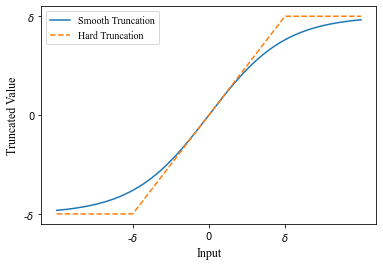

In [4]:
# Define the clamping function
def f(x, c):
    return np.clip(x, -c, c)

# Define the smooth approximation using tanh
def f_smooth(x,  c):
    return c * np.tanh(x/c)

# Generate x values
x = np.linspace(-10, 10, 400)

# Define c
c = 5
a = 1
# Plot the original clamping function
ticks = [-c, 0, c]
labels = [f'-$\\delta$', '0', '$\\delta$']
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

# Plot smooth approximations with different a values

plt.plot(x, f_smooth(x, c), label='Smooth Truncation')
plt.plot(x, f(x, c), label='Hard Truncation', linestyle='--')
plt.legend(prop={'family':'Times New Roman','size':10})
#plt.title('Clamping Function and its Smooth Approximations')
plt.xlabel('Input',fontsize=12,**csfont)
plt.ylabel(r'Truncated Value',fontsize=12,**csfont)
#plt.grid(True)
#plt.savefig("tanh_truncation.pdf")

In [5]:
1.6*1.14/(1.28*1.28)

1.1132812499999998

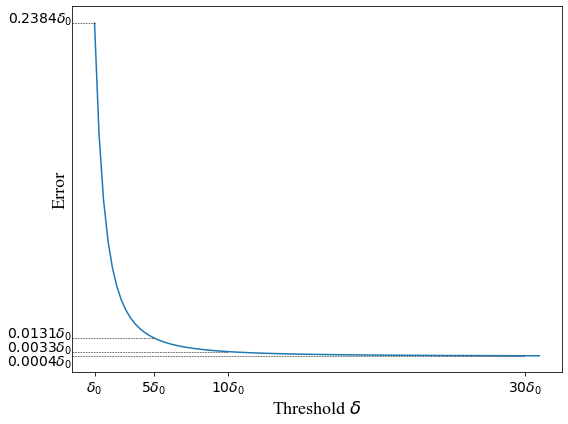

In [12]:
x = np.linspace(1,31,100)
y = 1-f_smooth(1, x)
plt.figure(figsize=(8,6))
plt.plot(x,y)
xticks = np.array([1,5,10,30])
xlabels = ['$\delta_0$','$5\delta_0$','$10\delta_0$','$30\delta_0$']
plt.xticks(xticks, xlabels,fontsize=14)
yticks = np.array([1-f_smooth(1, z) for z in xticks])
xlim = plt.xlim()
for i in range(4):
    xmax = (xticks[i] - xlim[0]) / (xlim[1] - xlim[0])
    plt.axhline(y=yticks[i], color='black', linestyle='--', xmax=xmax,lw = 0.5)
#ylabels = ['${:.4f}\delta_0$'.format(yticks[0]),'${:.4f}\delta_0$'.format(yticks[1]),'${:.4f}\delta_0$'.format(yticks[2]),'${:.4f}\delta_0$'.format(yticks[3])]
#plt.yticks(yticks, ylabels,fontsize=12)
#labels = plt.gca().get_yticklabels()
plt.yticks([])
for i, ytick in enumerate(yticks):
    ytick_label = '${:.4f}\delta_0$'.format(ytick)
    if i == 3:
        plt.text(-0.5, ytick-0.007, ytick_label, fontsize=14,ha='right',**csfont)
    else:
        plt.text(-0.5, ytick, ytick_label, fontsize=14,ha='right',**csfont)
plt.xlabel('Threshold $\delta$',fontsize=18,**csfont)
plt.ylabel('Error',fontsize=18,**csfont)
plt.tight_layout()
plt.savefig('Gap_plot.pdf')